[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ourownstory/neural_prophet/blob/master/tutorials/feature-use/global_modeling.ipynb)

# Global Model
When fitting a single forecasting model with shared weights using a dataset composed of many time series, we can achieve what is known as a **global model**. It is specially useful in cases in which (i) a single time series may not reflect the entire time series dynamics; or when (ii) demanding better generalization and model size saving. In this notebook, we will build a global model using data from the hourly load of the ERCOT region.

First, we load the data:

In [49]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes

import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet import set_random_seed
set_random_seed(8)
set_log_level("ERROR","INFO")

In [50]:
# data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
# df_ercot = pd.read_csv(data_location + "energy/ERCOT_load.csv")
df_ercot = pd.read_csv('ERCOT_load_2004_2021Sept.csv')
df_ercot.head()

ds    COAST    EAST  FAR_WEST   NORTH  NORTH_C  SOUTHERN  \
0  2004-01-01 01:00:00  7225.09  877.79   1044.89  745.79  7124.21   1660.45   
1  2004-01-01 02:00:00  6994.25  850.75   1032.04  721.34  6854.58   1603.52   
2  2004-01-01 03:00:00  6717.42  831.63   1021.10  699.70  6639.48   1527.99   
3  2004-01-01 04:00:00  6554.27  823.56   1015.41  691.84  6492.39   1473.89   
4  2004-01-01 05:00:00  6511.19  823.38   1009.74  686.76  6452.26   1462.76   

   SOUTH_C    WEST         y  
0  3639.12  654.61  22971.94  
1  3495.16  639.88  22191.52  
2  3322.70  623.42  21383.44  
3  3201.72  613.49  20866.56  
4  3163.74  613.32  20723.15

In [51]:
regions = list(df_ercot)[1:-1]
regions

['COAST',
 'EAST',
 'FAR_WEST',
 'NORTH',
 'NORTH_C',
 'SOUTHERN',
 'SOUTH_C',
 'WEST']

We are going to select data from a three years interval in our example (from 2004 to 2007).

In [52]:
df_list=list()
for cols in regions:
    aux=df_ercot[['ds',cols]].copy()
    aux=aux.iloc[:26301,:].copy()
    aux=aux.rename(columns={cols:'y'})
    df_list.append(aux)

In [53]:
df_list[0].head()

ds        y
0  2004-01-01 01:00:00  7225.09
1  2004-01-01 02:00:00  6994.25
2  2004-01-01 03:00:00  6717.42
3  2004-01-01 04:00:00  6554.27
4  2004-01-01 05:00:00  6511.19

We are going to define a model which predicts the next hour based on the last 24 hours. At first, we are going to split our data into train and test (with a 33% test proportion - 2 years train and 1 year test).

In [54]:
m=NeuralProphet(n_lags=24)
df_train_list,df_test_list=m.split_df(df_list,freq='H',valid_p=0.33)

Quick comparing single df before and after normalization.

Now we fit a model based on all of the normalized regions. Notice that the training procedure takes about 4 to 6 minutes since we are considering two years hourly data from 8 different regions.

## Global modeling - Global Normalization

In [55]:
m=NeuralProphet(n_lags=24)
metrics = m.fit(df_train_list,freq='H')

  0%|          | 0/357 [00:00<?, ?it/s]

  0%|          | 0/357 [00:00<?, ?it/s]

  0%|          | 0/357 [00:00<?, ?it/s]

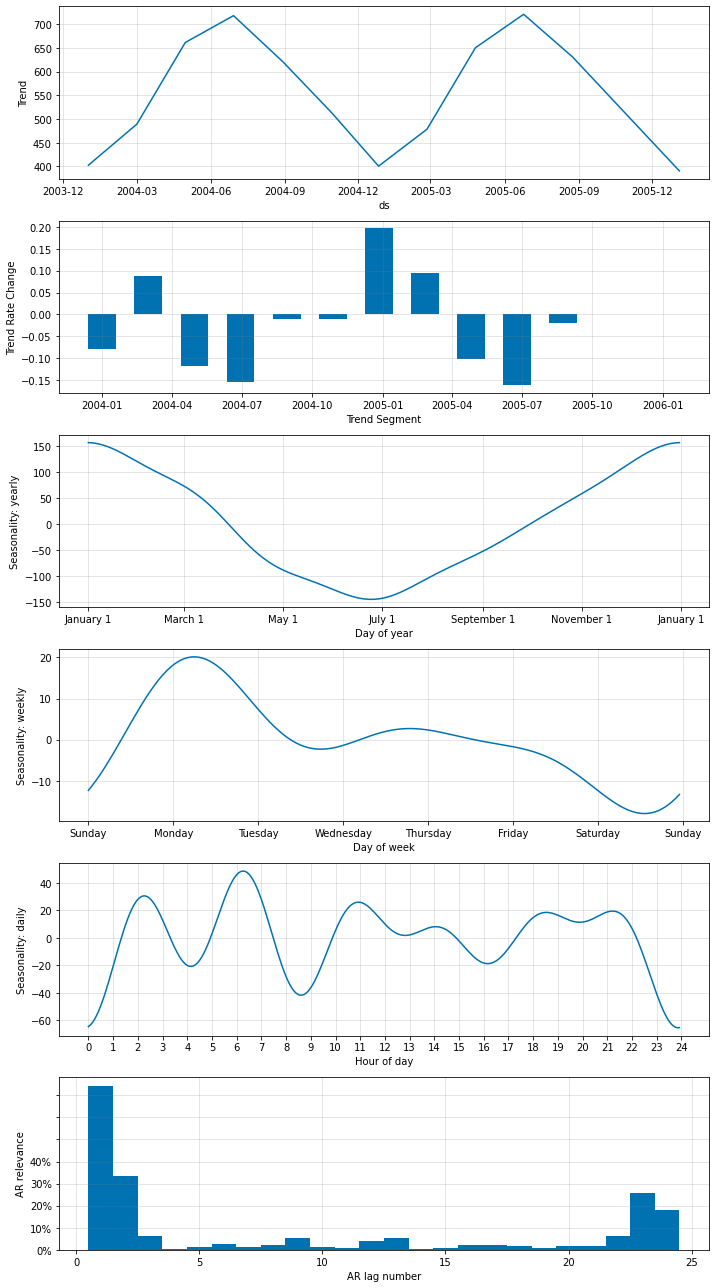

In [56]:
fig_param = m.plot_parameters()

In [57]:
test_metrics=m.test(df_test_list)
test_metrics

SmoothL1Loss         MAE        RMSE
0      0.001066  509.848313  530.556363

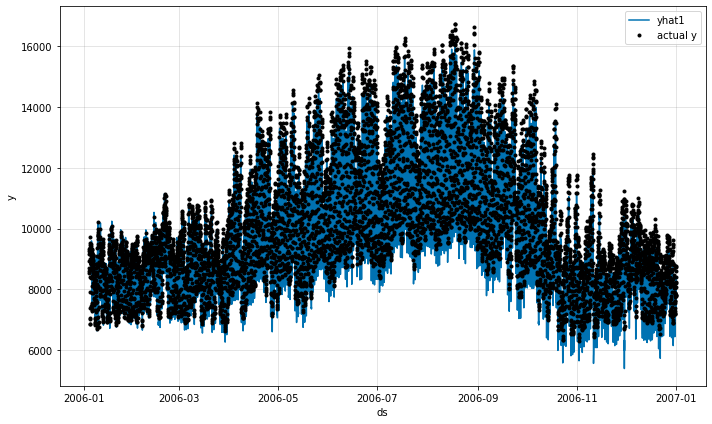

In [58]:
future = m.make_future_dataframe(df_test_list, n_historic_predictions=True)
forecast = m.predict(future)
fig = m.plot(forecast[0])

## Global Modeling - Local normalization

In [60]:
m=NeuralProphet(n_lags=24)
metrics = m.fit(df_train_list,freq='H',local_modeling=True,local_modeling_names=regions)

  0%|          | 0/357 [00:00<?, ?it/s]

  0%|          | 0/357 [00:00<?, ?it/s]

  0%|          | 0/357 [00:00<?, ?it/s]

In [61]:
# fig_param = m.plot_parameters() ## ATTENTION

In [62]:
test_metrics=m.test(df_test_list,local_modeling_names=regions)
test_metrics

SmoothL1Loss      MAE      RMSE
0      0.000412  0.02247  0.028142

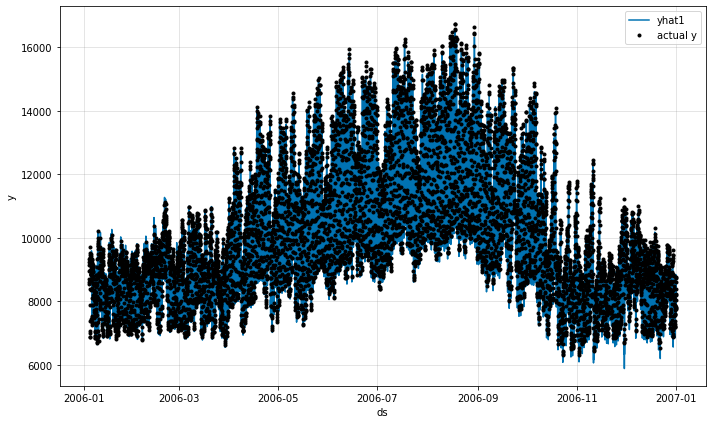

In [63]:
future = m.make_future_dataframe(df_test_list, n_historic_predictions=True)
forecast = m.predict(future,local_modeling_names=regions)
fig = m.plot(forecast[0])